### Although mAP metric is popular, I think we still need to write a new notebook to compute CV score
1. Most of the mAP calculators are integrated within particular frameworks such as detectron2, yolo, mmdet, etc... It might lack flexibility if we want to ensemble various models.
2. Some standalone codes only compute box-mAP, not segm-mAP

=> So I reimplement the code to compute mAP for this competition. **Note that it only support single class at the moment**. I use my Detectron2 model to make predictions as an example and I also compare with Detectron2 built-in CocoEvaluator

In [1]:
from pathlib import Path
import random, cv2, os
import matplotlib.pyplot as plt

In [2]:
import numpy as np
from tqdm.auto import tqdm
import pandas as pd
import cv2
import matplotlib.pyplot as plt

import base64
from pycocotools import _mask as coco_mask
import typing as t
import zlib
import json
import torch

In [3]:
class CFG:
    
    MODEL_PATH = "ckpts/segformer_epoch_118.pt"
    THRESHOLD = 0.40
    IMG_DIR = "/home/viktor/Documents/kaggle/hubmap-2023/kaggle-data/train"
    N_TRAIN = 1400 # Take first N_TRAIN images for training, rest for validation
    
    min_mask_area = 0 # minimum number of pixels of mask
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import json
from PIL import Image
from skimage.draw import polygon
from albumentations import Compose, Resize, HorizontalFlip, VerticalFlip, BboxParams
from torch.utils.data import Dataset, DataLoader


class HubmapDataset(Dataset):
        
    def __init__(self, image_dir, labels_file, n_train, mode='train'):
        
        assert mode in ['train', 'val'], "mode must be one of ['train', 'val']"
        self.mode = mode
        
        with open(labels_file, 'r') as json_file:
            self.json_labels = [json.loads(line) for line in json_file]

        if mode == 'train':
            self.json_labels = self.json_labels[:n_train]
        else:
            self.json_labels = self.json_labels[n_train:]

        self.image_dir = image_dir
        
        
        if mode == 'train':
            initial_augm = [
            
                
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                
                A.RandomBrightnessContrast(p=0.5, brightness_limit=0.2, contrast_limit=0.2),
                A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.1),
                A.CoarseDropout(max_holes=1, max_width=int(512 * 0.05), max_height=int(512 * 0.05), 
                                mask_fill_value=0, p=0.1),
                
                
                A.OneOf([
                        A.GaussNoise(var_limit=[10, 50]),
                        A.GaussianBlur(),
                        A.MotionBlur(),
                        ], p=0.1),
                A.MultiplicativeNoise(per_channel=True, multiplier=(0.95, 1.05)),
                
            ]
        else:
            initial_augm = []
        
        self.aug_list = initial_augm + [
                A.Resize(512, 512),
                A.Normalize(
                    mean= [0, 0, 0],
                    std= [1, 1, 1],
                    max_pixel_value = 255
                ),
                ToTensorV2(transpose_mask=True),
            ]
        
        # Create the augmentation pipeline
        self.augmentations = A.Compose(self.aug_list)

    def __len__(self):
        return len(self.json_labels)
        
    def __getitem__(self, idx):
        
        image_path = os.path.join(self.image_dir, f"{self.json_labels[idx]['id']}.tif")
        image = Image.open(image_path)
        
        
        # Get the mask
        mask = np.zeros((512, 512), dtype=np.float32)
        
        for annot in self.json_labels[idx]['annotations']:
            cords = annot['coordinates']
            if annot['type'] == "blood_vessel":
                for cord in cords:
                    rr, cc = polygon(np.array([i[1] for i in cord]), np.asarray([i[0] for i in cord]))
                    mask[rr, cc] = 1
                    
        image = np.array(image)

        # image = torch.tensor(np.array(image), dtype=torch.float32).permute(2, 0, 1)  # Shape: [C, H, W]
        # mask = torch.tensor(mask, dtype=torch.float32)


        augmented = self.augmentations(image=image, mask=mask)
        image, mask = augmented["image"], augmented["mask"]
        
        mean = torch.mean(image, dim=[1,2])
        std = torch.std(image, dim=[1,2])
        
        image = (image - mean[:, None, None]) / std[:, None, None]
        
        
        return image, mask


In [5]:
train_dataset = HubmapDataset(image_dir="/home/viktor/Documents/kaggle/hubmap-2023/kaggle-data/train", 
                              labels_file="/home/viktor/Documents/kaggle/hubmap-2023/kaggle-data/polygons.jsonl", 
                              n_train=CFG.N_TRAIN,
                              mode='train')

val_dataset = HubmapDataset(image_dir="/home/viktor/Documents/kaggle/hubmap-2023/kaggle-data/train", 
                              labels_file="/home/viktor/Documents/kaggle/hubmap-2023/kaggle-data/polygons.jsonl", 
                              n_train=CFG.N_TRAIN,
                              mode='val')

In [6]:
len(train_dataset), len(val_dataset)

(1400, 233)

In [7]:
# from transformers import SegformerForSemanticSegmentation
# import torch    
# import torch.nn as nn

# class Segformer(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.seg_model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b5",
#                                                          num_labels=1,
#                                                          ignore_mismatched_sizes=True,
#                                                          num_channels=3)
#         self.up = nn.Upsample(scale_factor=4, mode="bilinear")
        
#     def forward(self, x):
#         x = self.seg_model(x).logits
#         x = self.up(x)
#         return x



# model = Segformer()


# state_dict = torch.load(CFG.MODEL_PATH)
# model.load_state_dict(state_dict)
# model = model.to(CFG.device)


# model = model.to(CFG.device)

In [8]:
import segmentation_models_pytorch as smp
import torch.nn as nn

model = smp.Unet(
    encoder_name="mit_b5",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
)
model.segmentation_head[0] = nn.Conv2d(16, 3, kernel_size=(1, 1), stride=(1, 1))

state_dict = torch.load(CFG.MODEL_PATH)
model.load_state_dict(state_dict)

model = model.to(CFG.device)

In [9]:
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2

def preprocess_img_for_model_inference(img_path):
    # image = cv2.imread(img_path)
    image = Image.open(img_path)
    
    image = np.array(image)
    
    
    # apply 
    aug_list = [
                A.Resize(512, 512),
                A.Normalize(
                    mean= [0, 0, 0],
                    std= [1, 1, 1],
                    max_pixel_value = 255
                ),
                ToTensorV2(transpose_mask=True),
            ]
        
   # Create the augmentation pipeline
    augmentations = A.Compose(aug_list)
    
    
    # image = torch.tensor(image).permute(2, 0, 1).unsqueeze(0).float()
    image = augmentations(image=image)["image"].unsqueeze(0)
    
    
    mean = torch.mean(image, dim=[1,2])
    std = torch.std(image, dim=[1,2])
    
    image = (image - mean[:, None, None]) / std[:, None, None]
    
    return image    

In [10]:
def seg_to_det(
    seg: np.ndarray, 
):
    num_outputs, labels, stats, centroids = cv2.connectedComponentsWithStats(seg)
    boxes = stats[:, [cv2.CC_STAT_LEFT, cv2.CC_STAT_TOP, cv2.CC_STAT_WIDTH, cv2.CC_STAT_HEIGHT]]
    label_masks = [labels == i for i in range(num_outputs)]
    dets = {
        "boxes": np.stack([
            boxes[:, 0],
            boxes[:, 1],
            boxes[:, 0] + boxes[:, 2],
            boxes[:, 1] + boxes[:, 3],
        ], axis=1),
        "masks": [seg * m for m in label_masks],
    }
    dets["scores"] = [np.max(seg[m]) for m in label_masks]
    
    # remove dets element where 'boxes' = [0, 0, 512, 512]
    boxes_to_remove = [0, 0, 512, 512]
    indices_to_remove = np.where(np.all(dets["boxes"] == boxes_to_remove, axis=1))
    
    dets["boxes"] = np.delete(dets["boxes"], indices_to_remove, axis=0)
    dets["masks"] = [i for j, i in enumerate(dets["masks"]) if j not in indices_to_remove]
    dets["scores"] = np.delete(dets["scores"], indices_to_remove)
    
    
    # remove dets where np.sum(mask) < CFG.min_mask_area
    indices_to_remove = []
    for i, mask in enumerate(dets["masks"]):
        if np.sum(mask) < CFG.min_mask_area:
            indices_to_remove.append(i)
            
    dets["boxes"] = np.delete(dets["boxes"], indices_to_remove, axis=0)
    dets["masks"] = [i for j, i in enumerate(dets["masks"]) if j not in indices_to_remove]
    dets["scores"] = np.delete(dets["scores"], indices_to_remove)
    
    return dets

def predict(image):
    with torch.no_grad():
        pred = model(image)
        pred = torch.sigmoid(pred)
        pred = pred.squeeze().cpu().numpy()
        pred = pred[0, :, :]
    
    pred = (pred > CFG.THRESHOLD).astype(np.uint8)*255
    dets = seg_to_det(pred)
    pred_masks, pred_classes, scores, boxes = dets["masks"], [0]*len(dets["masks"]), dets["scores"], dets["boxes"]
    
    # convert pred_masks to uint8_t
    pred_masks = [m.astype(np.uint8) for m in pred_masks]
    
    return pred_masks, pred_classes, scores, boxes

def predict_and_load_image(img_path):
    image = preprocess_img_for_model_inference(img_path)
    
    
    image = image.to(CFG.device)
    return predict(image)

## segm-mAP code

In [11]:
import pycocotools.mask as mask_util

In [12]:
def voc_ap(rec, prec):
    """
    --- Official matlab code VOC2012---
    mrec=[0 ; rec ; 1];
    mpre=[0 ; prec ; 0];
    for i=numel(mpre)-1:-1:1
            mpre(i)=max(mpre(i),mpre(i+1));
    end
    i=find(mrec(2:end)~=mrec(1:end-1))+1;
    ap=sum((mrec(i)-mrec(i-1)).*mpre(i));
    """
    rec.insert(0, 0.0) # insert 0.0 at begining of list
    rec.append(1.0) # insert 1.0 at end of list
    mrec = rec[:]
    prec.insert(0, 0.0) # insert 0.0 at begining of list
    prec.append(0.0) # insert 0.0 at end of list
    mpre = prec[:]
    """
     This part makes the precision monotonically decreasing
        (goes from the end to the beginning)
        matlab: for i=numel(mpre)-1:-1:1
                    mpre(i)=max(mpre(i),mpre(i+1));
    """
    # matlab indexes start in 1 but python in 0, so I have to do:
    #     range(start=(len(mpre) - 2), end=0, step=-1)
    # also the python function range excludes the end, resulting in:
    #     range(start=(len(mpre) - 2), end=-1, step=-1)
    for i in range(len(mpre)-2, -1, -1):
        mpre[i] = max(mpre[i], mpre[i+1])
    """
     This part creates a list of indexes where the recall changes
        matlab: i=find(mrec(2:end)~=mrec(1:end-1))+1;
    """
    i_list = []
    for i in range(1, len(mrec)):
        if mrec[i] != mrec[i-1]:
            i_list.append(i) # if it was matlab would be i + 1
    """
     The Average Precision (AP) is the area under the curve
        (numerical integration)
        matlab: ap=sum((mrec(i)-mrec(i-1)).*mpre(i));
    """
    ap = 0.0
    for i in i_list:
        ap += ((mrec[i]-mrec[i-1])*mpre[i])
    return ap, mrec, mpre


In [32]:
import numpy as np
from sklearn.metrics import precision_recall_curve, auc

class MAPCalculatorSingleClass:
    def __init__(self, iou_threshold=0.6):
        self.true_positives = 0
        self.false_positives = 0
        self.total_gts = 0
        self.iou_threshold = iou_threshold

    def calculate_iou(self, pred_mask, gt_mask):
        intersection = np.logical_and(pred_mask, gt_mask)
        union = np.logical_or(pred_mask, gt_mask)
        return np.sum(intersection) / np.sum(union)

    def evaluate_masks(self, pred_masks, gt_masks):
        self.total_gts += len(gt_masks)
        if len(gt_masks) == 0:
            # If there are no ground truth masks, all predictions are false positives
            self.false_positives += len(pred_masks)
        else:
            # Compute IOU between each pair of predicted and ground truth masks
            ious = np.zeros((len(pred_masks), len(gt_masks)))
            for i, pred_mask in enumerate(pred_masks):
                for j, gt_mask in enumerate(gt_masks):
                    ious[i, j] = self.calculate_iou(pred_mask, gt_mask)
                    print(ious[i, j])

            # Match predicted masks to ground truth masks
            # True positive: IOU >= threshold with ground truth mask
            # False positive: IOU < threshold with all ground truth masks (including the ones that have already been matched to other predictions)
            
            # matched_gt_ids = []
            # for i in range(len(pred_masks)):
            #     j = np.argmax(ious[i])
            #     if ious[i, j] >= self.iou_threshold and j not in matched_gt_ids:
            #         self.true_positives += 1
            #         matched_gt_ids.append(j)
            #     else:
            #         self.false_positives += 1
                    
                    
            matched_gt_ids = []
            matched_pred_ids = []
            for i in range(len(pred_masks)):
                j = np.argmax(ious[i])
                if ious[i, j] >= self.iou_threshold and j not in matched_gt_ids and i not in matched_pred_ids:
                    self.true_positives += 1
                    matched_gt_ids.append(j)
                    matched_pred_ids.append(i)
                else:
                    self.false_positives += 1
            
            

    def evaluate(self):
        # calculate the precision   
        precision = self.true_positives / (self.true_positives + self.false_positives)
        
        # calculate recall
        recall = self.true_positives / self.total_gts
        
        return precision, recall
        

### Our custom code

In [33]:
from skimage.morphology import binary_dilation

th_vals = np.arange(0.1, 1.0, 0.05)
map_vals = {}
for th_val in th_vals:
    map_vals[th_val] = MAPCalculatorSingleClass(iou_threshold=th_val)



# mAP_calc = MAPCalculatorSingleClass()

pbar = enumerate(val_dataset)
pbar = tqdm(pbar, total=len(val_dataset))
    
areas_gt = []
areas_pred = []

heights_gt = []
heights_pred = []

widths_gt = []
widths_pred = []

aspect_ratios_gt = []
aspect_ratios_pred = []

true_positives_total = 0
false_positives_total = 0

for i, (images, target_masks) in pbar:
    
    
    width, height = images.shape[2], images.shape[1]
    images = images.unsqueeze(0).to(CFG.device)    
    
    dets = seg_to_det(target_masks.squeeze(0).cpu().numpy().astype(np.uint8)*255)
    
    target_masks_all = target_masks.squeeze(0).cpu().numpy().astype(np.uint8)
    
    target_masks, pred_classes, scores_target, bboxes_target = dets["masks"], [0]*len(dets["masks"]), dets["scores"], dets["boxes"]
    # convert pred_masks to uint8_t
    target_masks = [m.astype(np.uint8) for m in target_masks]

    # make prediction
    # pred_masks, pred_classes, scores = predict(predictor, img)
    pred_masks, pred_classes, scores_pred, bboxes_pred = predict(images)
    
    # for m in pred_masks:
    #     print("unique elements: ", np.unique(m))
    
    pred_masks_all = np.sum(pred_masks, axis=0)
    
    
    # calculate number of true positives
    true_positives = np.sum(pred_masks_all * target_masks_all)
    false_positives = np.sum(pred_masks_all * (1 - target_masks_all))
    
    true_positives_total += true_positives
    false_positives_total += false_positives
    
    min_area_dilation = 1e4
    # dilate all pred masks below min_area_dilation
    # for i, m in enumerate(pred_masks):
    #     if m.sum() < min_area_dilation:
    #         pred_masks[i] = binary_dilation(m/255).astype(np.uint8)*255
        
    
    min_area = 0e4
    max_area = 0e4
    min_height = 5
    min_width = 5
    # # remove pred_masks with area < 200
    remove_inds = []
    for i, m in enumerate(pred_masks):
        if (m.sum() < max_area and m.sum() > min_area) or (bboxes_pred[i,3] - bboxes_pred[i,1] < min_height or bboxes_pred[i,2] - bboxes_pred[i,0] < min_width):
            remove_inds.append(i)
    pred_masks = [m for i, m in enumerate(pred_masks) if i not in remove_inds]
    pred_classes = [c for i, c in enumerate(pred_classes) if i not in remove_inds]
    scores_pred = [s for i, s in enumerate(scores_pred) if i not in remove_inds]
    bboxes_pred = bboxes_pred[~np.isin(np.arange(len(bboxes_pred)), remove_inds)]
    
    # remove_inds = []
    # for i, m in enumerate(target_masks):
    #     if m.sum() < min_area or (bboxes_target[i,3] - bboxes_target[i,1] < min_height and bboxes_target[i,2] - bboxes_target[i,0] < min_width):
    #         remove_inds.append(i)
    # target_masks = [m for i, m in enumerate(target_masks) if i not in remove_inds]
    # pred_classes = [c for i, c in enumerate(pred_classes) if i not in remove_inds]
    # scores_target = [s for i, s in enumerate(scores_target) if i not in remove_inds]
    # bboxes_target = bboxes_target[~np.isin(np.arange(len(bboxes_target)), remove_inds)]
    
    
    
    
    
    for i, m in enumerate(pred_masks):
        areas_pred.append(m.sum())
        
        height = bboxes_pred[i, 2] - bboxes_pred[i, 0]
        heights_pred.append(height)
        
        width = bboxes_pred[i, 3] - bboxes_pred[i, 1]
        widths_pred.append(width)
        
        aspect_ratio = width / height
        aspect_ratios_pred.append(aspect_ratio)
        
    
    for i, m in enumerate(target_masks):
        areas_gt.append(m.sum())
        
        height = bboxes_target[i, 2] - bboxes_target[i, 0]
        heights_gt.append(height)
        
        width = bboxes_target[i, 3] - bboxes_target[i, 1]
        widths_gt.append(width)
        
        aspect_ratio = width / height
        aspect_ratios_gt.append(aspect_ratio)
    
    
    # print(len(pred_masks), len(target_masks))
    # mAP_calc.evaluate_masks(pred_masks, target_masks)
    
    
    pred_masks = [m>0.5 for m in pred_masks]
    target_masks = [m>0.5 for m in target_masks]
    
    for th_val in th_vals:
        map_vals[th_val].evaluate_masks(pred_masks, target_masks)
    
    break

  0%|          | 0/233 [00:00<?, ?it/s]

0.765
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.8776536312849162
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.7836734693877551
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.2676348547717842
0.40159462861938733
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.836764705882353
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.6496945010183299
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.7590361445783133
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.7413793103448276
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.8955785512699906
0.0
0.765
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.8776536312849162
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.7836734693877551
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.2676348547717842
0.40159462861938733
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.836764705882353
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.6496945010183299
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0

In [15]:
# mAP_calc.evaluate()

In [16]:
precisions = []
recalls = []

for th_val in th_vals:
    precision, recall = map_vals[th_val].evaluate()
    print("th_val: ", th_val, "precision: ", precision, "recall: ", recall)
    
    precisions.append(precision)
    recalls.append(recall)
    

th_val:  0.1 precision:  0.6758839528558477 recall:  0.7553191489361702
th_val:  0.15000000000000002 precision:  0.6677243880326382 recall:  0.7462006079027356
th_val:  0.20000000000000004 precision:  0.6622846781504986 recall:  0.7401215805471124
th_val:  0.25000000000000006 precision:  0.655938349954669 recall:  0.7330293819655522
th_val:  0.30000000000000004 precision:  0.6450589301903898 recall:  0.720871327254306
th_val:  0.3500000000000001 precision:  0.6314596554850408 recall:  0.7056737588652482
th_val:  0.40000000000000013 precision:  0.6201269265639165 recall:  0.6930091185410334
th_val:  0.45000000000000007 precision:  0.5951949229374434 recall:  0.6651469098277609
th_val:  0.5000000000000001 precision:  0.571622846781505 recall:  0.6388044579533941
th_val:  0.5500000000000002 precision:  0.5448776065276518 recall:  0.6089159067882473
th_val:  0.6000000000000002 precision:  0.5067996373526745 recall:  0.5663627152988855
th_val:  0.6500000000000001 precision:  0.4582955575702

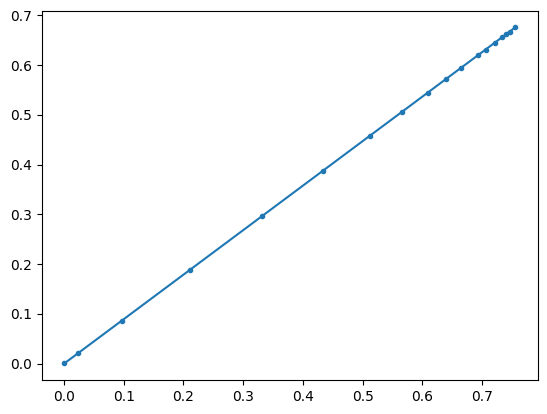

In [17]:
# plot precision recall curve
plt.figure()

plt.plot(recalls, precisions, marker='.', label='Precision-Recall Curve')

## Competition metric
- In this competition, the metric is segm-mAP@0.6

# dilation study (no excluding of small areas)


min area: 0 (no dilation) -> CV (mAP@0.6): 0.29340945900722193


min area: 0 (dilation of <1e4 area) -> CV (mAP@0.6): 0.29340945900722193


min area: 0 (dilation of <6e4 area) -> CV (mAP@0.6): 0.3025598833942809




# dilation study (no excluding of small areas)


min area: 0 (no dilation) -> CV (mAP@0.6): 0.29340945900722193


min area: 0 (dilation of <1e4 area + excluding areas between 0 and 2e4) -> CV (mAP@0.6): 0.33750069599634336


min area: 0 (dilation of <1e4 area + excluding areas between 0 and 5e4) -> CV (mAP@0.6): 0.3523174522299635


min area: 0 -> CV (mAP@0.6): 0.3139922130574431


min area: 2e4 -> CV (mAP@0.6): 0.33750069599634336


min area: 4e4 -> CV (mAP@0.6): 0.3515683621145983


min area: 5e4 -> CV (mAP@0.6): 0.3523174


min area: 6e4 -> CV (mAP@0.6): 0.3474716751175245




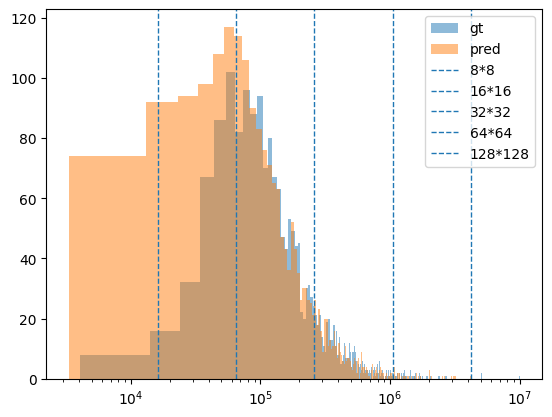

In [18]:
plt.hist(areas_gt, bins=1000, label='gt', alpha=0.5);
plt.hist(areas_pred, bins=1000, label='pred', alpha=0.5);

# set vertical line at 64*64
plt.axvline(255*8*8, linestyle='dashed', linewidth=1, label='8*8')
plt.axvline(255*16*16, linestyle='dashed', linewidth=1, label='16*16')
plt.axvline(255*32*32, linestyle='dashed', linewidth=1, label='32*32')
plt.axvline(255*64*64, linestyle='dashed', linewidth=1, label='64*64')
plt.axvline(255*128*128, linestyle='dashed', linewidth=1, label='128*128')

plt.xscale('log')

plt.legend()

Text(0.5, 0, 'height')

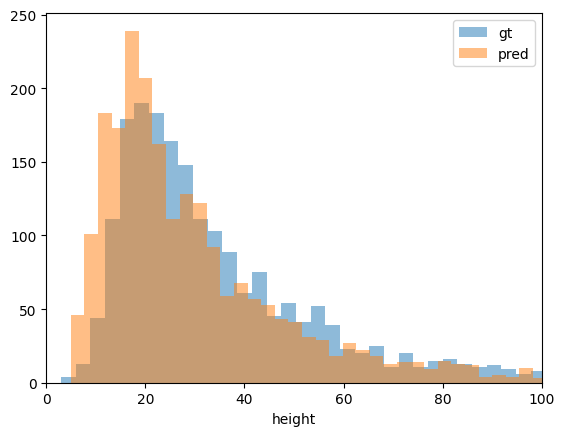

In [19]:
plt.hist(heights_gt, bins=100, label='gt', alpha=0.5);
plt.hist(heights_pred, bins=100, label='pred', alpha=0.5);

plt.xlim(0, 100)
plt.legend()
plt.xlabel('height')

Text(0.5, 0, 'width')

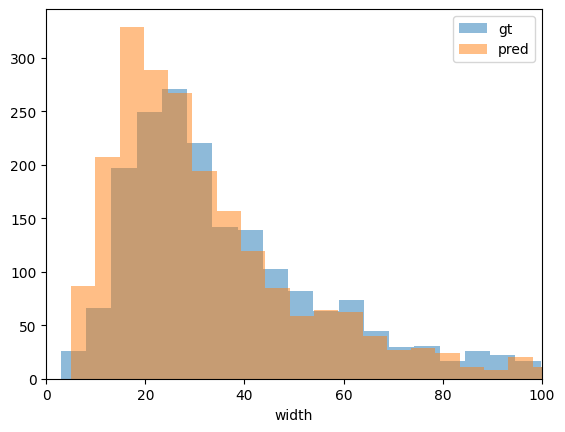

In [20]:
plt.hist(widths_gt, bins=100, label='gt', alpha=0.5);
plt.hist(widths_pred, bins=100, label='pred', alpha=0.5);

plt.xlim(0, 100)
plt.legend()
plt.xlabel('width')

Text(0.5, 0, 'aspect_ratio = width / height')

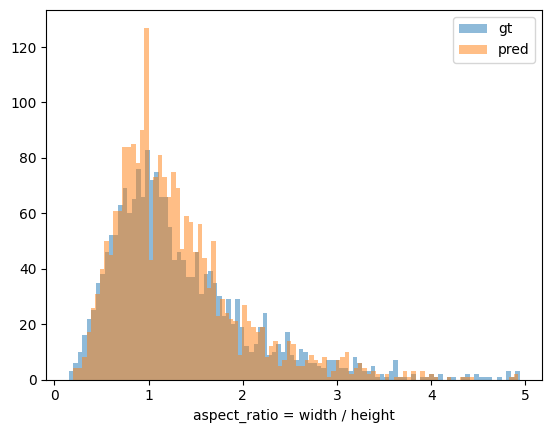

In [21]:
# remove nan from aspect_ratios_gt
aspect_ratios_gt = [a for a in aspect_ratios_gt if not np.isnan(a) and not np.isinf(a) and np.abs(a) < 5]
aspect_ratios_pred  = [a for a in aspect_ratios_pred if not np.isnan(a) and not np.isinf(a) and np.abs(a) < 5]

plt.hist(aspect_ratios_gt, bins=100, label='gt', alpha=0.5);
plt.hist(aspect_ratios_pred, bins=100, label='pred', alpha=0.5);

# plt.xlim(0, 2)
plt.legend()
plt.xlabel('aspect_ratio = width / height')

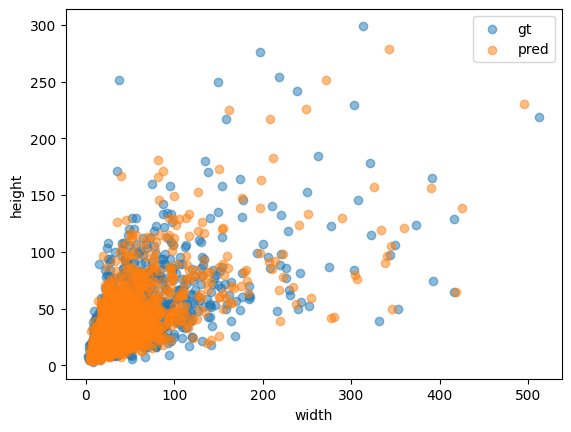

In [22]:
# scatter plot of width and height
plt.scatter(widths_gt, heights_gt, label='gt', alpha=0.5);
plt.scatter(widths_pred, heights_pred, label='pred', alpha=0.5);

plt.xlabel('width')
plt.ylabel('height')

plt.legend()

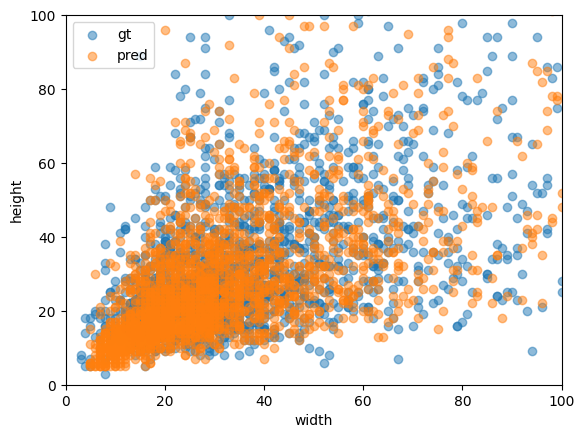

In [23]:
# scatter plot of width and height
plt.scatter(widths_gt, heights_gt, label='gt', alpha=0.5)
plt.scatter(widths_pred, heights_pred, label='pred', alpha=0.5)

# xlim 0 to 100
plt.xlim(0, 100)
plt.ylim(0, 100)

plt.xlabel('width')
plt.ylabel('height')

plt.legend()

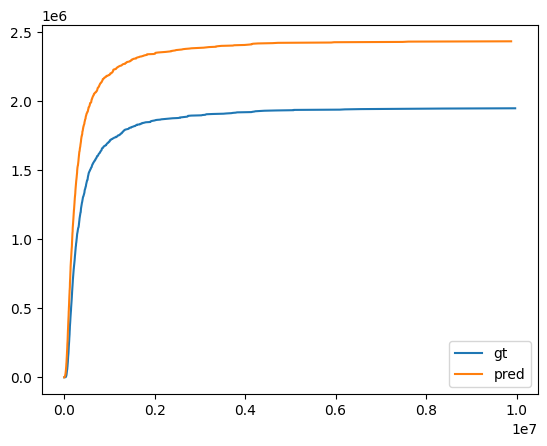

In [24]:
areas_gt = np.sort(areas_gt)
indices = np.arange(0, len(areas_gt), 1)
indices_cumsum = np.cumsum(indices)
plt.plot(areas_gt, indices_cumsum, label='gt')


areas_pred = np.sort(areas_pred)
indices = np.arange(0, len(areas_pred), 1)
indices_cumsum = np.cumsum(indices)

plt.plot(areas_pred, indices_cumsum, label='pred')

plt.legend()

/tmp/ipykernel_1620882/3341612647.py:5: RuntimeWarning: divide by zero encountered in divide
  indices_cumsum_diff = np.diff(indices_cumsum) / np.diff(areas_gt)
/tmp/ipykernel_1620882/3341612647.py:12: RuntimeWarning: divide by zero encountered in divide
  indices_cumsum_diff = np.diff(indices_cumsum) / np.diff(areas_pred)


(0.0, 2000000.0)

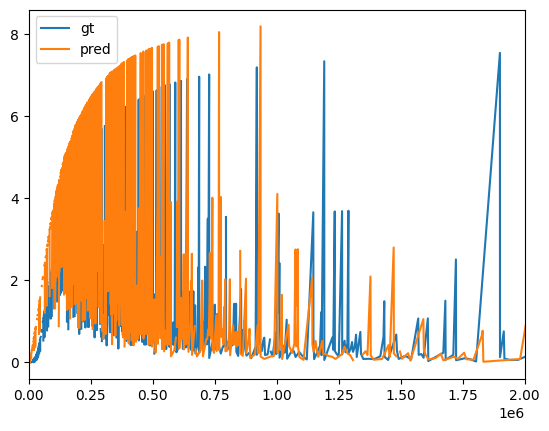

In [25]:
areas_gt = np.sort(areas_gt)
indices = np.arange(0, len(areas_gt), 1)
indices_cumsum = np.cumsum(indices)
# get derivative of indices_cumsum with respect to areas_gt
indices_cumsum_diff = np.diff(indices_cumsum) / np.diff(areas_gt)
plt.plot(areas_gt[:-1], indices_cumsum_diff, label='gt')


areas_pred = np.sort(areas_pred)
indices = np.arange(0, len(areas_pred), 1)
indices_cumsum = np.cumsum(indices)
indices_cumsum_diff = np.diff(indices_cumsum) / np.diff(areas_pred)
plt.plot(areas_pred[:-1], indices_cumsum_diff, label='pred')

plt.legend()
plt.xlim(0, 0.2e7)

In [34]:
with open("/home/viktor/Documents/kaggle/hubmap-2023/kaggle-data/polygons.jsonl", 'r') as json_file:
    json_labels = [json.loads(line) for line in json_file]

ids = []
for label in json_labels:
    id = label['id']
    ids.append(id)

In [35]:

df_labels = pd.DataFrame({'id':ids})
# convert id to string
df_labels['id'] = df_labels['id'].astype(str, errors='ignore')
df_labels

,id
0,0006ff2aa7cd
1,00168d1b7522
2,0033bbc76b6b
3,003504460b3a
4,004daf1cbe75
...,...
1628,ff434af74304
1629,ff4897b3eda6
1630,ff66dec71c4c
1631,ff99cdef0f2a


In [36]:
df_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1633 entries, 0 to 1632
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      1633 non-null   object
dtypes: object(1)
memory usage: 12.9+ KB


In [37]:
df_meta = pd.read_csv("/home/viktor/Documents/kaggle/hubmap-2023/kaggle-data/tile_meta.csv")
df_meta['id'] = df_meta['id'].astype(str)
df_meta

,id,source_wsi,dataset,i,j
0,0006ff2aa7cd,2,2,16896,16420
1,000e79e206b7,6,3,10240,29184
2,00168d1b7522,2,2,14848,14884
3,00176a88fdb0,7,3,14848,25088
4,0033bbc76b6b,1,1,10240,43008
...,...,...,...,...,...
7028,ffd37b5c6598,13,3,13824,21504
7029,ffd3d193c71e,3,2,7680,16896
7030,ffd77e2517af,13,3,15872,28160
7031,ffe3cbb81f72,10,3,15456,23000


In [38]:
df_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7033 entries, 0 to 7032
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          7033 non-null   object
 1   source_wsi  7033 non-null   int64 
 2   dataset     7033 non-null   int64 
 3   i           7033 non-null   int64 
 4   j           7033 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 274.9+ KB


In [39]:
# take all rows from df_meta where id is in ids
df_1 = df_meta[df_meta['id'].isin(ids)]

# get distinct source_wsi
df_1['source_wsi'].unique()

array([2, 1, 3, 4])

In [40]:
df_1

,id,source_wsi,dataset,i,j
0,0006ff2aa7cd,2,2,16896,16420
2,00168d1b7522,2,2,14848,14884
4,0033bbc76b6b,1,1,10240,43008
5,003504460b3a,3,2,8192,11776
8,004daf1cbe75,3,2,6144,11264
...,...,...,...,...,...
7016,ff434af74304,4,2,3072,22528
7017,ff4897b3eda6,4,2,11776,20992
7021,ff66dec71c4c,3,2,5120,10752
7025,ff99cdef0f2a,4,2,5120,24064


: 